**Step 1: Load Data Set**

Install and import the ucimlrepo library.

Load the Forest Fires dataset:

Predictors: Features from forest_fires.data.features.

Target: forest_fires.data.targets.

In [122]:
# Data
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import (mean_squared_error,
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)


forest_fires = fetch_ucirepo(id=162)
X = forest_fires.data.features
y = forest_fires.data.targets


# Display dataset structure
print(X.info())
print(X.describe())
print(y.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 48.6+ KB
None
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192 

**Step 2: Exploratory Data Analysis (EDA)**

Examine the dataset structure and summary statistics.

Analyze correlations between predictors and the target variable.

Plot scatterplots for key predictors vs. the target.

Generate a residual plot to check for randomness in residuals.

In [123]:
# Combine features and target
df = pd.concat([X, y], axis=1)

# Log-transform target variable
df['log_area'] = np.log1p(df['area'])

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['month', 'day'], drop_first=True)

# Display dataset structure and summary statistics
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          517 non-null    int64  
 1   Y          517 non-null    int64  
 2   FFMC       517 non-null    float64
 3   DMC        517 non-null    float64
 4   DC         517 non-null    float64
 5   ISI        517 non-null    float64
 6   temp       517 non-null    float64
 7   RH         517 non-null    int64  
 8   wind       517 non-null    float64
 9   rain       517 non-null    float64
 10  area       517 non-null    float64
 11  log_area   517 non-null    float64
 12  month_aug  517 non-null    bool   
 13  month_dec  517 non-null    bool   
 14  month_feb  517 non-null    bool   
 15  month_jan  517 non-null    bool   
 16  month_jul  517 non-null    bool   
 17  month_jun  517 non-null    bool   
 18  month_mar  517 non-null    bool   
 19  month_may  517 non-null    bool   
 

In [124]:
# Correlation with log_area
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['log_area'].sort_values(ascending=False)
print("Correlation with log_area:")
print(correlation_with_target)

Correlation with log_area:
log_area     1.000000
area         0.524134
month_dec    0.139159
month_sep    0.082638
DMC          0.067153
wind         0.066973
DC           0.066360
X            0.061995
temp         0.053487
FFMC         0.046799
Y            0.038838
day_sat      0.036372
month_may    0.032423
day_tue      0.032202
rain         0.023311
day_sun      0.004438
day_wed      0.000645
month_feb   -0.003330
month_jul   -0.005035
day_mon     -0.006160
ISI         -0.010347
day_thu     -0.022189
month_oct   -0.024000
month_nov   -0.035009
month_aug   -0.035026
month_jun   -0.035363
month_jan   -0.049558
RH          -0.053662
month_mar   -0.082736
Name: log_area, dtype: float64


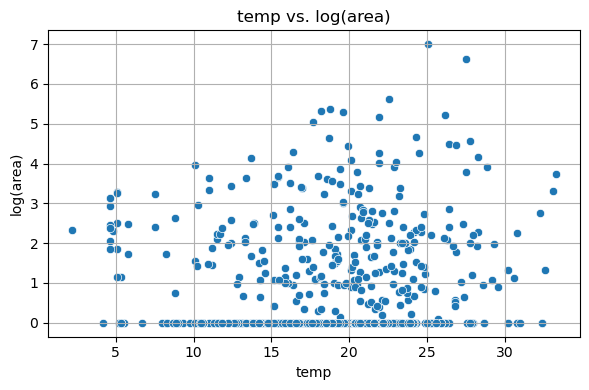

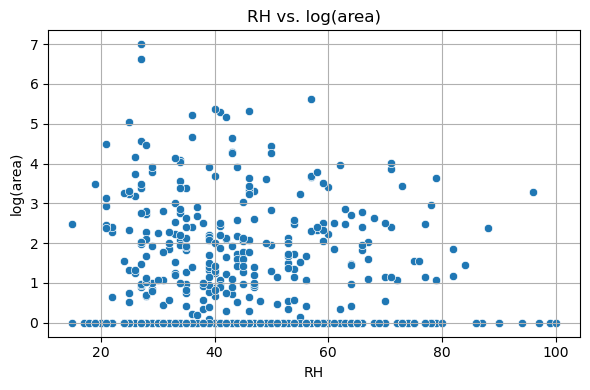

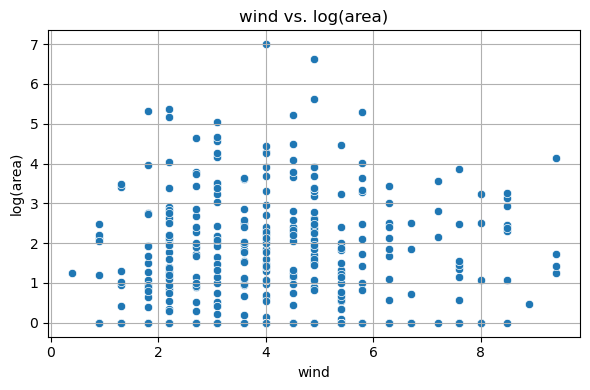

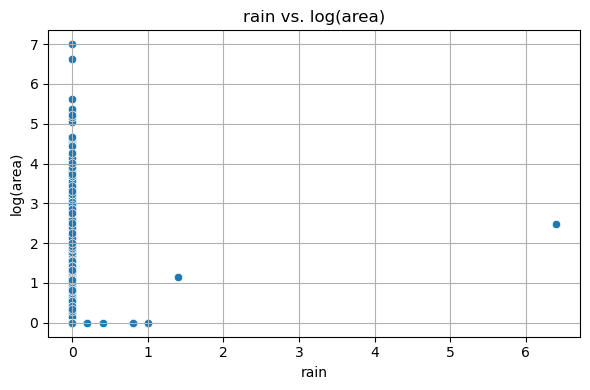

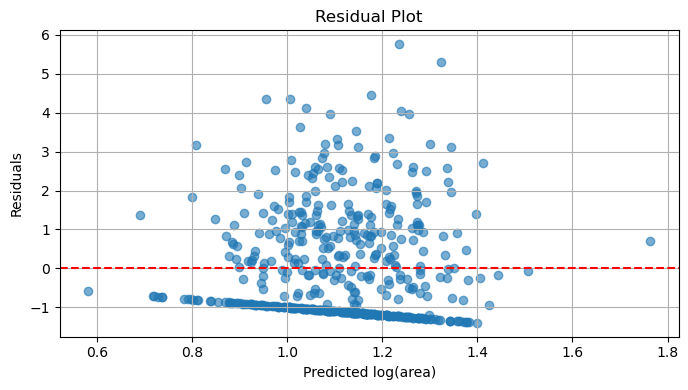

In [125]:
# Plot scatterplots for key predictors
key_predictors = ['temp', 'RH', 'wind', 'rain']
for col in key_predictors:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df['log_area'])
    plt.title(f'{col} vs. log(area)')
    plt.xlabel(col)
    plt.ylabel('log(area)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Fit linear regression for residual plot
X_model = df[key_predictors]
y_model = df['log_area']
model = LinearRegression()
model.fit(X_model, y_model)
predictions = model.predict(X_model)
residuals = y_model - predictions

# Residual plot
plt.figure(figsize=(7, 4))
plt.scatter(predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted log(area)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

**Step 3: Fit Regression Models**

Fit a baseline multiple linear regression model with key predictors.

Include nonlinear terms (e.g., quadratic transformations for significant predictors).

Add interaction terms (e.g., between predictors with strong correlations).

Incorporate indicator variables if categorical variables are present.

Apply transformations (e.g., logarithmic transformations for skewed predictors).

In [126]:
# Log-transform the target variable to reduce skewness
df['log_area'] = np.log1p(df['area'])

# Convert categorical variables ('month', 'day') into dummy variables
categorical_cols = [col for col in ['month', 'day'] if col in df.columns]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Fit a baseline linear regression model using key predictors
import statsmodels.formula.api as smf
baseline_formula = 'log_area ~ temp + RH + wind + rain'
baseline_model = smf.ols(formula=baseline_formula, data=df).fit()
print(baseline_model.summary())


                            OLS Regression Results                            
Dep. Variable:               log_area   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.345
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.252
Time:                        22:37:07   Log-Likelihood:                -903.77
No. Observations:                 517   AIC:                             1818.
Df Residuals:                     512   BIC:                             1839.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7420      0.443      1.674      0.0

In [127]:
# Add nonlinear (squared) terms
df['temp_squared'] = df['temp'] ** 2
df['wind_squared'] = df['wind'] ** 2

# Add interaction term (temp × RH)
df['temp_RH'] = df['temp'] * df['RH']

# Apply log transformation to skewed predictors
df['log_RH'] = np.log1p(df['RH'])
df['log_wind'] = np.log1p(df['wind'])

# Fit an enhanced model with all new features
enhanced_predictors = ['temp', 'RH', 'wind', 'rain',
                       'temp_squared', 'wind_squared', 'temp_RH',
                       'log_RH', 'log_wind'] + \
                      [col for col in df.columns if col.startswith('month_') or col.startswith('day_')]

enhanced_formula = 'log_area ~ ' + ' + '.join(enhanced_predictors)
enhanced_model = smf.ols(formula=enhanced_formula, data=df).fit()

print(enhanced_model.summary())

                            OLS Regression Results                            
Dep. Variable:               log_area   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.406
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0898
Time:                        22:37:07   Log-Likelihood:                -887.87
No. Observations:                 517   AIC:                             1830.
Df Residuals:                     490   BIC:                             1944.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.4136      3.98

**Step 4: Evaluate Model Diagnostics**

Compare models using metrics like R2R^2, adjusted R2R^2, AIC, and BIC.

Plot residuals and create Q-Q plots to assess normality.

Identify influential observations using Cook's Distance.

In [128]:
# One-hot encode categorical columns
categorical_cols = [col for col in ['month', 'day'] if col in df.columns]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Baseline model
baseline_formula = 'log_area ~ temp + RH + wind + rain'
baseline_model = smf.ols(formula=baseline_formula, data=df).fit()

# Enhanced model feature engineering
df['temp_squared'] = df['temp'] ** 2
df['wind_squared'] = df['wind'] ** 2
df['temp_RH'] = df['temp'] * df['RH']
df['log_RH'] = np.log1p(df['RH'])
df['log_wind'] = np.log1p(df['wind'])

# Enhanced model
enhanced_predictors = ['temp', 'RH', 'wind', 'rain',
                       'temp_squared', 'wind_squared', 'temp_RH',
                       'log_RH', 'log_wind'] + \
                      [col for col in df.columns if col.startswith('month_') or col.startswith('day_')]
enhanced_formula = 'log_area ~ ' + ' + '.join(enhanced_predictors)
enhanced_model = smf.ols(formula=enhanced_formula, data=df).fit()


# Compare models

comparison = pd.DataFrame({
    'Model': ['Baseline', 'Enhanced'],
    'R-squared': [baseline_model.rsquared, enhanced_model.rsquared],
    'Adjusted R-squared': [baseline_model.rsquared_adj, enhanced_model.rsquared_adj],
    'AIC': [baseline_model.aic, enhanced_model.aic],
    'BIC': [baseline_model.bic, enhanced_model.bic]
})
print("\nModel Comparison:\n", comparison)


Model Comparison:
       Model  R-squared  Adjusted R-squared          AIC          BIC
0  Baseline   0.010402            0.002671  1817.532067  1838.772282
1  Enhanced   0.069405            0.020026  1829.749707  1944.446865


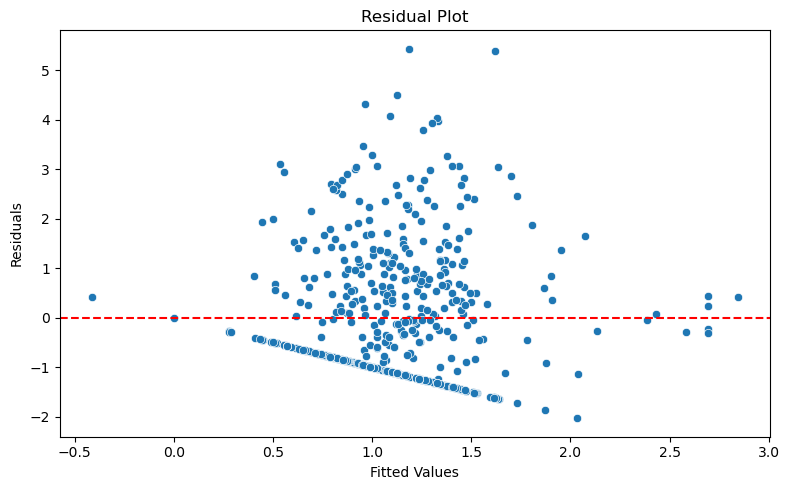

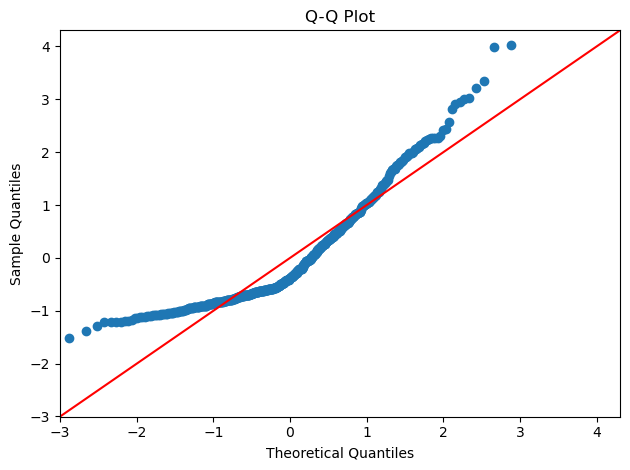

c:\Users\steve\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


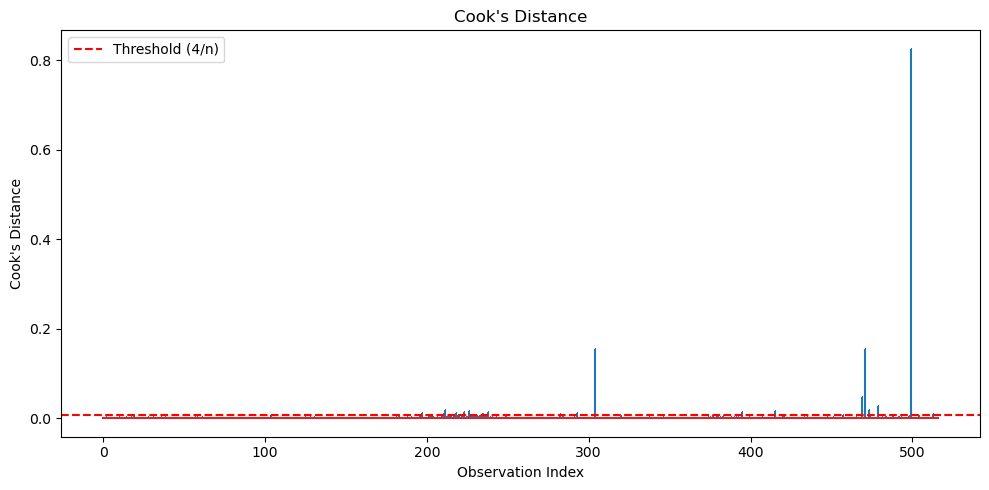

In [129]:
# Residual plot
residuals = enhanced_model.resid
fitted_vals = enhanced_model.fittedvalues

plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Cook's Distance

influence = enhanced_model.get_influence()
cooks_d = influence.cooks_distance[0]

plt.figure(figsize=(10, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(4 / len(cooks_d), color='red', linestyle='--', label='Threshold (4/n)')
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.legend()
plt.tight_layout()
plt.show()

**Step 5: Apply Regularization**

Use Ridge (L2) and Lasso (L1) regression from sklearn to handle multicollinearity.

Extract coefficients and calculate Mean Squared Error (MSE).

Compare the performance of Ridge and Lasso models.


In [138]:
# Feature list
features = ['temp', 'RH', 'wind', 'rain',
            'temp_squared', 'wind_squared', 'temp_RH',
            'log_RH', 'log_wind'] + \
           [col for col in df.columns if col.startswith('month_') or col.startswith('day_')]

X = df[features]
y = df['log_area']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge Regression (L2)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
ridge_mse = mean_squared_error(y_test, ridge_pred)

# Lasso Regression (L1)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
lasso_mse = mean_squared_error(y_test, lasso_pred)

# Coefficients
ridge_coefs = pd.Series(ridge.coef_, index=X.columns, name='Ridge Coefficients')
lasso_coefs = pd.Series(lasso.coef_, index=X.columns, name='Lasso Coefficients')
coef_df = pd.concat([ridge_coefs, lasso_coefs], axis=1)

# MSE comparison
mse_df = pd.DataFrame({
    'Model': ['Ridge', 'Lasso'],
    'Test MSE': [ridge_mse, lasso_mse]
})

# Print results
print("\nModel Coefficients:\n")
print(coef_df.round(4))


Model Coefficients:

              Ridge Coefficients  Lasso Coefficients
temp                     -0.7654              0.0000
RH                       -0.3474             -0.0000
wind                     -0.4050              0.0000
rain                      0.0104              0.0000
temp_squared              0.7701              0.0025
wind_squared              0.1429              0.0000
temp_RH                   0.1752              0.0000
log_RH                    0.2606             -0.0000
log_wind                  0.3161              0.0000
month_aug                 0.0728             -0.0000
month_dec                 0.2023              0.0838
month_feb                 0.0824              0.0000
month_jan                -0.0092             -0.0000
month_jul                 0.0657              0.0000
month_jun                 0.0189             -0.0000
month_mar                 0.0740             -0.0000
month_may                 0.1522              0.0280
month_nov               

In [139]:
print("\nMean Squared Error (Test Set):\n")
print(mse_df)


Mean Squared Error (Test Set):

   Model  Test MSE
0  Ridge  2.214094
1  Lasso  2.165065


**Step 6: Prepare Data for Binary Classification**

Create a binary target variable based on a threshold in y (e.g., median or other percentile).

Select relevant predictors and scale them using StandardScaler.

In [131]:
# Create binary target: 1 if area > median, else 0
threshold = df['area'].median()
df['is_large_fire'] = (df['area'] > threshold).astype(int)

# Define predictors
predictors = ['temp', 'RH', 'wind', 'rain',
              'temp_squared', 'wind_squared', 'temp_RH',
              'log_RH', 'log_wind'] + \
             [col for col in df.columns if col.startswith('month_') or col.startswith('day_')]

X = df[predictors]
y_binary = df['is_large_fire']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Wrap into DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Output preview
print("Scaled features (first 5 rows):")
print(X_scaled_df.head())

Scaled features (first 5 rows):
       temp        RH      wind      rain  temp_squared  wind_squared  \
0 -1.842640  0.411724  1.498614 -0.073268     -1.514216      1.525838   
1 -0.153278 -0.692456 -1.741756 -0.073268     -0.311322     -1.107114   
2 -0.739383 -0.692456 -1.518282 -0.073268     -0.830596     -1.054551   
3 -1.825402  3.233519 -0.009834  0.603155     -1.506486     -0.199797   
4 -1.291012  3.356206 -1.238940 -0.073268     -1.220379     -0.961967   

    temp_RH    log_RH  log_wind  month_aug  ...  month_may  month_nov  \
0 -1.434258  0.568855  1.333571  -0.743339  ...  -0.062318  -0.044023   
1 -0.750006 -0.638446 -2.443622  -0.743339  ...  -0.062318  -0.044023   
2 -1.186713 -0.638446 -1.927922  -0.743339  ...  -0.062318  -0.044023   
3  0.071640  2.369573  0.168097  -0.743339  ...  -0.062318  -0.044023   
4  1.330772  2.426979 -1.396958  -0.743339  ...  -0.062318  -0.044023   

   month_oct  month_sep   day_mon   day_sat   day_sun   day_thu   day_tue  \
0  -0.172860 

In [132]:
print("Binary target distribution:")
print(y_binary.value_counts())

Binary target distribution:
is_large_fire
0    259
1    258
Name: count, dtype: int64


**Step 7: Train and Evaluate a Logistic Regression Model**

Train a logistic regression model using the scaled predictors.

Display coefficients and the intercept.

Predict probabilities and binary outcomes.

Evaluate performance using accuracy, confusion matrix, precision, recall, and F1-score.

In [136]:
X = df[predictors]
y = df['is_large_fire']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Display coefficients and intercept
print("\nIntercept:", model.intercept_[0])
coefs = pd.Series(model.coef_[0], index=X.columns)
print("\nCoefficients:\n", coefs.sort_values(ascending=False))


Intercept: 0.03226168675409139

Coefficients:
 log_RH          1.003437
temp_squared    0.705691
month_dec       0.577932
wind_squared    0.390741
month_sep       0.307787
month_may       0.251068
day_sat         0.114472
day_mon         0.096573
month_feb       0.092245
month_jul       0.089534
month_mar       0.080330
day_tue         0.060271
day_thu         0.045344
day_wed         0.045308
rain            0.043122
month_aug       0.034480
log_wind        0.024518
month_jun       0.010615
month_oct      -0.034016
day_sun        -0.116137
temp_RH        -0.151731
month_jan      -0.176029
month_nov      -0.184624
wind           -0.232129
temp           -0.234792
RH             -0.668419
dtype: float64


In [137]:
# Predict probabilities and binary outcomes
y_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred = model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.3f}")
print("\nConfusion Matrix:\n", conf_matrix,"\n")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.529

Confusion Matrix:
 [[28 25]
 [24 27]] 

Precision: 0.519
Recall: 0.529
F1-score: 0.524

Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.53      0.53        53
           1       0.52      0.53      0.52        51

    accuracy                           0.53       104
   macro avg       0.53      0.53      0.53       104
weighted avg       0.53      0.53      0.53       104



**Step 8 Check Assumptions**

Use Variance Inflation Factor (VIF) to assess multicollinearity among predictors.


In [135]:
# Standardize predictors before calculating VIF
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i)
                   for i in range(X_scaled.shape[1])]


# Display
print("\nVariance Inflation Factor (VIF) for each feature:\n")
print(vif_data.sort_values("VIF", ascending=False))


Variance Inflation Factor (VIF) for each feature:

         Feature         VIF
2           wind  715.081917
8       log_wind  211.280357
5   wind_squared  179.144011
0           temp  171.652481
4   temp_squared   75.050625
7         log_RH   37.664464
1             RH   31.664856
6        temp_RH   23.830414
9      month_aug   17.522425
19     month_sep   16.199122
15     month_mar    6.450490
13     month_jul    5.317138
10     month_dec    3.257078
11     month_feb    3.229125
14     month_jun    3.226946
18     month_oct    2.833503
22       day_sun    1.821484
21       day_sat    1.736644
20       day_mon    1.710342
23       day_thu    1.633531
24       day_tue    1.623368
25       day_wed    1.557746
12     month_jan    1.367521
16     month_may    1.292034
3           rain    1.198372
17     month_nov    1.141483


**Step 9: Summarize Findings**

Compare regression models and classification results.

Highlight trade-offs between model simplicity, performance, and interpretability.

Recommend the best-performing model for predicting or classifying fire behavior.

---
In this project, we tested both regression and classification models to predict wildfire behavior. The baseline linear regression model performed poorly, with an R² of just 0.01. The enhanced model, which included interaction terms, nonlinear features, and encoded categories, showed a small improvement (R² = 0.07) but added complexity without much gain. Regularized models helped more—Ridge regression improved generalization by shrinking coefficients, while Lasso performed best overall. It achieved the lowest test error (MSE = 2.165) and simplified the model by eliminating less useful features, keeping only the most relevant predictors like temperature squared, month_dec, and month_sep.

For classification, we trained a logistic regression model to predict whether a fire would be large or small. While the model was easy to interpret, it didn’t perform well. Accuracy was just 52.9%, and the precision, recall, and F1-score all hovered around 0.52—barely better than random guessing. High multicollinearity among features (with VIFs over 700 for some) likely contributed to its poor performance.

Overall, Lasso regression was the strongest model. It offered the best balance between performance, simplicity, and interpretability for predicting fire size. Logistic regression, while interpretable, wasn’t reliable enough for classifying fire risk. A better approach for classification would likely involve nonlinear models like Random Forest or XGBoost, and possibly redefining what counts as a "large" fire.

